In [ ]:
import pymysql
import pandas as pd

#подключение к базе данных
def get_connection():
    connection = pymysql.connect(host='database-3.chim8btj05zt.us-east-1.rds.amazonaws.com',
                                 user='admin',
                                 password='01035007',
                                 db='test',
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
    return connection


connection = get_connection()

try:
    with connection.cursor() as cursor:
        print("выгрузка датасета")
        s = "SELECT count(*) AS count FROM sort_v2 WHERE ttype = -1"
        cursor.execute(s)
        c1 = cursor.fetchone()['count']
        s = "SELECT count(*) AS count FROM sort_v2 WHERE ttype = 1"
        cursor.execute(s)
        c2 = cursor.fetchone()['count']
        min_c = min(c1, c2)

        s = "SELECT ttext_stem, ttype FROM sort_v2 WHERE ttype = -1 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_n = pd.DataFrame(result)
        print(data_n.head(5))
        s = "SELECT ttext_stem, ttype FROM sort_v2 WHERE ttype = 1 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_p = pd.DataFrame(result)
        print(data_p.head(5))

        raw_data = pd.concat([data_p, data_n], ignore_index = True)
        raw_data = raw_data.sample(frac=1).reset_index(drop=True)  
        print(f"Обучающий набор: {raw_data.shape}")

        print("выгрузка тестовых данных")
        s = "SELECT count(*) AS count FROM linis_texts WHERE ttype = -1 OR ttype = -2"
        cursor.execute(s)
        c1 = cursor.fetchone()['count']
        s = "SELECT count(*) AS count FROM linis_texts WHERE ttype = 1 OR ttype = 2"
        cursor.execute(s)
        c2 = cursor.fetchone()['count']
        min_c = min(c1, c2)

        s = "SELECT ttext_stem, ttype FROM linis_texts WHERE ttype = -1 OR ttype = -2 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_n = pd.DataFrame(result)
        print(data_n.head(5))

        s = "SELECT ttext_stem, ttype FROM linis_texts WHERE ttype = 1 OR ttype = 2 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_p = pd.DataFrame(result)
        print(data_p.head(5))

        test_data = pd.concat([data_p, data_n], ignore_index = True)
        #test_data = test_data.loc[test_data['ttype'] != 0]

        data_p = None
        data_n = None
        result = None

        test_data = test_data.sample(frac=1).reset_index(drop=True)  
        print(f"Тестовые данные: {test_data.shape}")
    
finally:
    connection.close()

выгрузка датасета
                                          ttext_stem  ttype
0  работа|полный|пиддес|равнодушие|скука|каждый|з...     -1
1  коллега|сидеть|рубиться|urban|terror|долбать|в...     -1
2                    user|говорят|обещаной|год|ждать     -1
3  желать|хороший|полёт|удачный|посадка|очень|сил...     -1
4  обновить|леший|surf|работать|простоплеер|груст...     -1
                                          ttext_stem  ttype
0  user|школотый|поверь|самый|смех|общество|профи...      1
1  весь|таки|немного|похожий|мальчик|весь|равно|х...      1
2                         rt|user|идиотка|испугаться      1
3  rt|user|угол|сидеть|погибать|голод|ещё|порция|...      1
4  user|значит|страшилка|смех|блин|посмотреть|вес...      1
Обучающий набор: (223846, 2)
выгрузка тестовых данных
                                          ttext_stem  ttype
0  htm|обсуждать|сайт|весь|рядовой|гражданин|жить...     -2
1  приватизация|это|первородный|грех|антикоммунис...     -2
2  обычный|дело|улыбка|шутка

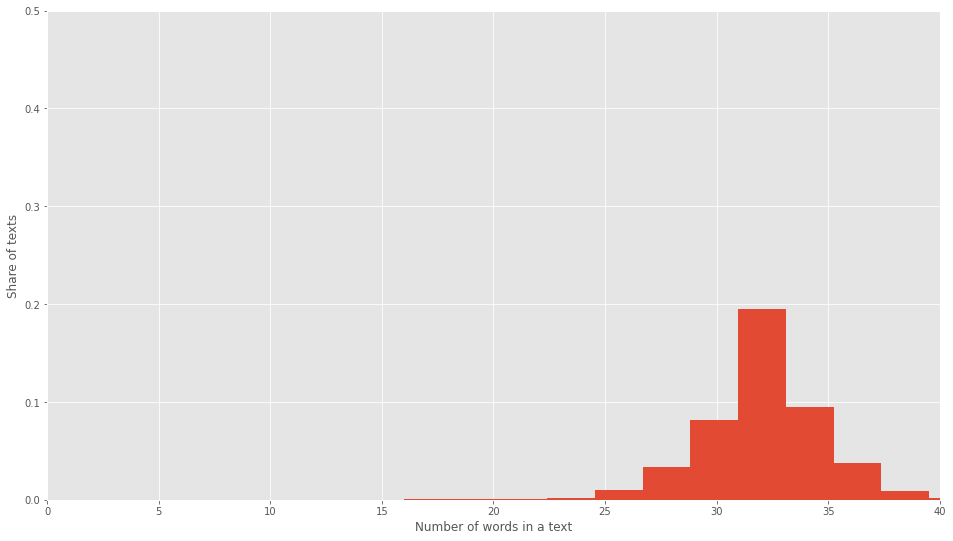

In [ ]:
#гистограмма наиболее часто встречающегося количества слов
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(16, 9)) 
# facecolor='g'
len_of_sent = test_data['ttext_stem'].apply(lambda x: len(x.split('|')))
n, bins, patches = plt.hist(len_of_sent, 50, density=True)
plt.xlabel('Number of words in a text')
plt.ylabel('Share of texts')
plt.axis([0, 40, 0, 0.5])
plt.grid(True)
plt.show()

#больше всего предложений длиной 8 слов. выбираем количество анализируемых слов = 25

In [ ]:
#загрузка модели Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import numpy as np
from gensim.models import Word2Vec
from google.colab import drive

drive.mount('/gdrive')
model = Word2Vec.load("/gdrive/My Drive/Colab Notebooks/w2v_1000/model1000_iter_8.word2vec")
model.delete_temporary_training_data()

DIM = model.vector_size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(model.wv.vocab.keys())

SENTENCE_LENGTH = 25

print("подготовка обучающего набора")
data = [row.split('|') for row in raw_data['ttext_stem']]
X = tokenizer.texts_to_sequences(data) 
X = pad_sequences(X, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X[0])}")
print(X)

Y = [1 if d == 1 else 0 for d in raw_data['ttype']]
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("подготовка тестового набора новостей")
test_d = [row.split('|') for row in test_data['ttext_stem']]
X_test2 = tokenizer.texts_to_sequences(test_d) 
X_test2 = pad_sequences(X_test2, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X_test2[0])}")
print(X_test2)

Y_test2 = [1 if d == 1 or d == 2 else 0 for d in test_data['ttype']]
print(Y_test2)


Using TensorFlow backend.


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


подготовка обучающего набора
Количество слов в предложении: 25
[[    0     0     0 ...    82  3185  1507]
 [    0     0     0 ...    24    25    26]
 [    0     0     0 ...   840  1509 14120]
 ...
 [    0     0     0 ...  1215   594   626]
 [    0     0     0 ...    25    26   398]
 [    0     0     0 ...  3303  1030  1031]]
[1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 

In [ ]:
#загрузка слов из словаря модели
e_matrix = []
for word in model.wv.vocab.keys():
    try:
        e_matrix.append(model.wv[word])
        if len(e_matrix) >= 300000:
            break
    except:
        print("Пропущено слово при заполнении модели")
        continue

print(f"Размерность словаря для embedding- {len(e_matrix)}")

NUM = len(e_matrix)
e_matrix = np.array(e_matrix, dtype=object)
print(e_matrix.shape)
print(e_matrix)

Размерность словаря для embedding- 181874
(181874, 1000)
[[-0.40454161167144775 0.12993285059928894 0.7127326130867004 ...
  0.10584969818592072 -0.8944813013076782 -0.6959888935089111]
 [-0.1578376591205597 0.10478681325912476 -0.30030837655067444 ...
  -0.28371313214302063 0.16417500376701355 0.3342585563659668]
 [0.7434800267219543 0.41508015990257263 1.604353666305542 ...
  0.48045238852500916 -1.240762710571289 0.10171331465244293]
 ...
 [-0.06994505971670151 0.0321773923933506 0.07513144612312317 ...
  -0.03570457920432091 0.06348524242639542 0.019250229001045227]
 [-0.002316100290045142 -0.06704910099506378 -0.0321541503071785 ...
  -0.0599646270275116 0.0416359081864357 0.019572574645280838]
 [-0.05430953577160835 -0.10703196376562119 0.03356761485338211 ...
  0.20355257391929626 0.0005478154052980244 -0.07364808768033981]]


In [ ]:
from keras import backend as K 

# Метрики 
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras.layers import Dense, concatenate, Activation, Dropout, LSTM
from keras.models import Model

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32')
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH,
                          weights=[e_matrix], trainable=False)(tweet_input)
layer = LSTM(64)(tweet_encoder)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)
model = Model(tweet_input,outputs=layer)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary() # Модель с замороженными emdedding слоям

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 1000)          181874000 
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                272640    
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/lstm-frozen-embeddings_1-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Train on 143260 samples, validate on 35816 samples
Epoch 1/10
143260/143260 [==============================] - 213s 1ms/step - loss: 0.3547 - accuracy: 0.8147 - precision: 0.8148 - recall: 0.8164 - f1: 0.8099 - val_loss: 0.3341 - val_accuracy: 0.8285 - val_precision: 0.8175 - val_recall: 0.8434 - val_f1: 0.8255
Epoch 2/10
143260/143260 [==============================] - 213s 1ms/step - loss: 0.3021 - accuracy: 0.8517 - precision: 0.8493 - recall: 0.8554 - f1: 0.8481 - val_loss: 0.3365 - val_accuracy: 0.8288 - val_precision: 0.8427 - val_recall: 0.8065 - val_f1: 0.8190
Epoch 3/10
143260/143260 [==============================] - 211s 1ms/step - loss: 0.2544 - accuracy: 0.8797 - precision: 0.8802 - recall: 0.8802 - f1: 0.8766 - val_loss: 0.3543 - val_accuracy: 0.8272 - val_precision: 0.8195 - val_recall: 0.8374 - val_f1: 0.8234
Epoch 4/10
143260/143260 [======================

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
model.load_weights('/gdrive/My Drive/Colab Notebooks/lstm-.hdf5')

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора твитов:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))
print("Оценки тестового набора новостей:")
predicted = np.round(model.predict(X_test2))
print(classification_report(Y_test2, predicted, digits=3))

In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/lstm-frozen-embeddings_2-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
#model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings-08-0.82.hdf5')

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора твитов:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))
print("Оценки тестового набора новостей:")
predicted = np.round(model.predict(X_test2))
print(classification_report(Y_test2, predicted, digits=3))

In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
model.load_weights('/gdrive/My Drive/Colab Notebooks/lstm-frozen-embeddings-08-0.82.hdf5')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/lstm-frozen2-embeddings-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
#model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings-_____.hdf5')

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора твитов:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))
print("Оценки тестового набора новостей:")
predicted = np.round(model.predict(X_test2))
print(classification_report(Y_test2, predicted, digits=3))


In [ ]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', precision, recall, f1])
model.summary()# Модель с размороженным emdedding слоем

In [ ]:
checkpoint = ModelCheckpoint("lstm-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
model.load_weights('lstm-trainable-____.hdf5')

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора твитов:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))
print("Оценки тестового набора новостей:")
predicted = np.round(model.predict(X_test2))
print(classification_report(Y_test2, predicted, digits=3))